In [ ]:
  # 나눔 폰트 설치
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf

In [52]:
# 파일이 들어있는 폴더 삭제
import os
import shutil

dir_path = "/content/test_images"

if os.path.exists(dir_path):
    shutil.rmtree(dir_path)

# 얼굴형 인식 모델

## 1. 프로젝트 목적
- 초개인화가 뷰티를 비롯해 시장 전반의 소비 트랜드로 자리잡으면서 퍼스널컬러 등 개인 맞춤 서비스가 인기를 끌고있다. 여기서 더 나아가 자신의 얼굴형을 판별 받고 그에 맞는 스타일링을 한다면 자신에게 최적화된 이미지 컨설팅이 가능할 것으로 보여 얼굴형을 판별해주는 모델 구현을 진행하고자 한다.

## 2. 데이터 선정
- 데이터는 캐글의 Face Shape Preprocessed 데이터를 선택하였으며, Heart, Oblong, Round, Square, Oval 다섯가지의 얼굴형으로 분류된 이미지 데이터로 구성되어있다.

- 데이터 : https://www.kaggle.com/datasets/zeyadkhalid/faceshape-processed?select=dataset
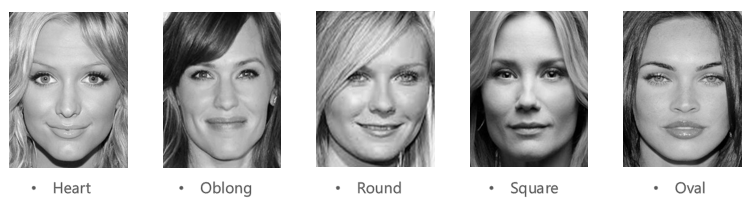
## 3. 가설 설정
- 얼굴형 판별 모델을 구현하여 사진 속 인물의 얼굴형을 판별 할 수 있다.

## 4. 모델 구현 및 적용

### 1) 데이터 가져오기 및 전처리

In [4]:
# kaggle 연동
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# kaggle에서 dataset 가져오기
!kaggle datasets download -d zeyadkhalid/faceshape-processed
!unzip /content/faceshape-processed.zip

In [45]:
# 필요한 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import dlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as patches

import warnings
warnings.filterwarnings("ignore")

In [7]:
# 가져온 이미지 데이터들을 원하는 크기(학습에 필요한 크기)로 크롭 후 저장하는 함수
def make_new_dataset(image_dir,make_dir):
  # image_dir : 이미지들이 있는 폴더 경로
  # make_dir : 크롭한 이미지들을 저장할 폴더 경로
  os.mkdir(make_dir)
  foldernames = os.listdir(image_dir) # 하위 폴더 리스트
  for i in foldernames:
    make_dir2 = make_dir + '/' + i
    os.mkdir(make_dir2)
    foldernames2 = os.listdir(image_dir+'/'+i)
    for j in foldernames2:
      make_dir3 = make_dir2 + '/' + j
      os.mkdir(make_dir3)
      filenames = os.listdir(image_dir + '/' + i + '/' + j)
      for k in filenames:
        file_path = image_dir + '/' + i + '/' + j + '/' + k
        image = Image.open(file_path)
        croppedImage =image.crop((0, 60, 190, 250)) # 원하는 크기로 이미지 크롭
        croppedImage.save(make_dir3 + '/' + k) # 자른 이미지 저장

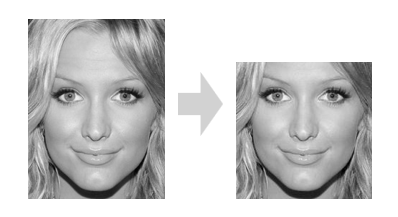

In [8]:
make_new_dataset('/content/dataset','/content/new_dataset')

In [9]:
# 데이터 가져오기 및 전처리
train_datagen = ImageDataGenerator(rescale=1./255, # 정규화
                                    horizontal_flip = True, # 이미지를 수평으로 뒤집기
                                    brightness_range=(0.8,1.2)) # 밝기 조절

test_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip = True,
                                  brightness_range=(0.8,1.2))

training_set = train_datagen.flow_from_directory('/content/new_dataset/train',
                                                 target_size = (256,256),
                                                 batch_size = 64,
                                                 color_mode = 'grayscale',
                                                 shuffle = True,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/new_dataset/test',
                                            target_size = (256,256),
                                            batch_size = 64,
                                            color_mode = 'grayscale',
                                            shuffle = True,
                                            class_mode = 'categorical')

Found 3981 images belonging to 5 classes.
Found 998 images belonging to 5 classes.


In [10]:
# Train, Test 데이터 분리
X_train, y_train = next(training_set)
X_test, y_test = next(test_set)

In [11]:
# label 확인
labels = list(training_set.class_indices)
labels

['Heart', 'Oblong', 'Oval', 'Round', 'Square']

### 2) 모델 만들기 및 학습

In [12]:
# Build model (Custom CNN Model)
model = Sequential()
model.add(Conv2D(8, (7, 7), activation='relu', padding="valid", input_shape=(256,256,1)))
model.add(MaxPooling2D(pool_size=(5,5),padding="valid", strides=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu', padding="valid"))
model.add(MaxPooling2D(pool_size=(3,3),padding="valid", strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding="valid"))
model.add(MaxPooling2D(pool_size=(3,3),padding="valid", strides=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation="softmax"))

model.summary()
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 8)       400       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 32)      6432      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 64)       0

In [14]:
# Custom early stop
class ValAccEarlyStop(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ValAccEarlyStop, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [15]:
# Training phase
history = model.fit(training_set,
                    epochs = 50,
                    validation_data = test_set,
                    shuffle = True,
                    callbacks=[ValAccEarlyStop(0.73)])

Epoch 1/50
63/63 [==============================] - 11s 144ms/step - loss: 1.6090 - accuracy: 0.2108 - val_loss: 1.6074 - val_accuracy: 0.1994
Epoch 2/50
63/63 [==============================] - 8s 131ms/step - loss: 1.6022 - accuracy: 0.2369 - val_loss: 1.5981 - val_accuracy: 0.2956
Epoch 3/50
63/63 [==============================] - 8s 126ms/step - loss: 1.5927 - accuracy: 0.2668 - val_loss: 1.5814 - val_accuracy: 0.2796
Epoch 4/50
63/63 [==============================] - 8s 126ms/step - loss: 1.5710 - accuracy: 0.2826 - val_loss: 1.5570 - val_accuracy: 0.2936
Epoch 5/50
63/63 [==============================] - 8s 128ms/step - loss: 1.5406 - accuracy: 0.3157 - val_loss: 1.5159 - val_accuracy: 0.3417
Epoch 6/50
63/63 [==============================] - 8s 126ms/step - loss: 1.4500 - accuracy: 0.3878 - val_loss: 1.4016 - val_accuracy: 0.4078
Epoch 7/50
63/63 [==============================] - 8s 126ms/step - loss: 1.3557 - accuracy: 0.4333 - val_loss: 1.2992 - val_accuracy: 0.4459
Epoch

In [16]:
# Evaluate Model
score= model.evaluate_generator(test_set)
print("Accuracy = ",score[1])

Accuracy =  0.7164328694343567


In [18]:
# Save model
model.save("face-shape-recognizer.h5")

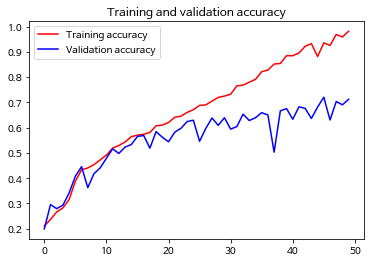

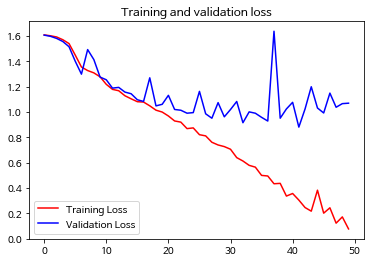

In [19]:
# Visualize Loss & Accuracy
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 3) 생성한 모델을 이용하여 얼굴형을 판단하는 함수 만들기

In [20]:
# 사진 속 인물의 눈코입을 찾아 수평으로 맞춰준 후 얼굴만 크롭해주는 함수
def crop_image(image): # (190,190,3) shape 및 dtype='unit8' 형태의 array로 입력해야함
  sp = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat') # 얼굴의 랜드마크를 찾아주는 모델 불러오기
  detector = dlib.get_frontal_face_detector()

  dets = detector(image,1) # 이미지에서 얼굴 영역을 찾는다.

  if len(dets) == 0: # 얼굴영역의 갯수가 0일 경우
    print('cannot find faces!')

  objs =dlib.full_object_detections() # 얼굴 수평맞춰줄때 사용

  for detection in dets:
    s = sp(image, detection) # sp() : 얼굴의 랜드마크를 찾는다.
    objs.append(s)

  image = dlib.get_face_chips(image, objs, size=256, padding=0.25)
  return np.array(image)

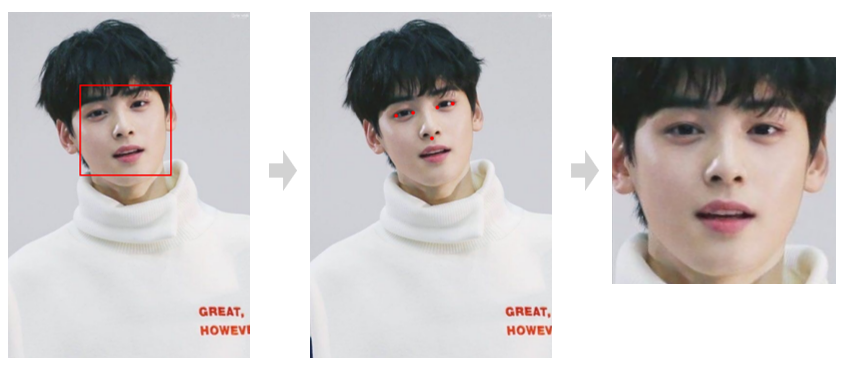

In [21]:
# Convert RGB to Gray
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [22]:
def what_is_my_face_shape(image_path):
  labels = ['Heart(하트형)', 'Oblong(긴 얼굴)', 'Oval(계란형)', 'Round(둥근형)', 'Square(사각형)']

  img = dlib.load_rgb_image(image_path) # 이미지 불러오기
  crop_img = crop_image(img) # 얼굴 크롭
  gray = rgb2gray(crop_img.reshape(256,256,3)) #gray로 변환
  gray = gray.reshape(256,256,1)

  gray = image.img_to_array(gray)
  gray = np.expand_dims(gray, axis=0)
  images = np.vstack([gray])

  pred = np.argmax(model.predict(gray, verbose=0),axis=1)[0]

  result = labels[pred]

  fig, axes = plt.subplots(1, 2, figsize=(5, 4.5))
  fig.suptitle(f'사진 속 인물의 얼굴형은 \n<{result}> 입니다.',fontsize=15)
  axes[0].imshow(img)
  axes[0].set_title('Original')
  axes[0].axis('off') # 원본이미지
  axes[1].imshow(crop_img.reshape(256,256,3)) # 얼굴 크롭이미지
  axes[1].set_title('Crop')
  axes[1].axis('off')

### 4) 얼굴형 판단 함수 실행해보기

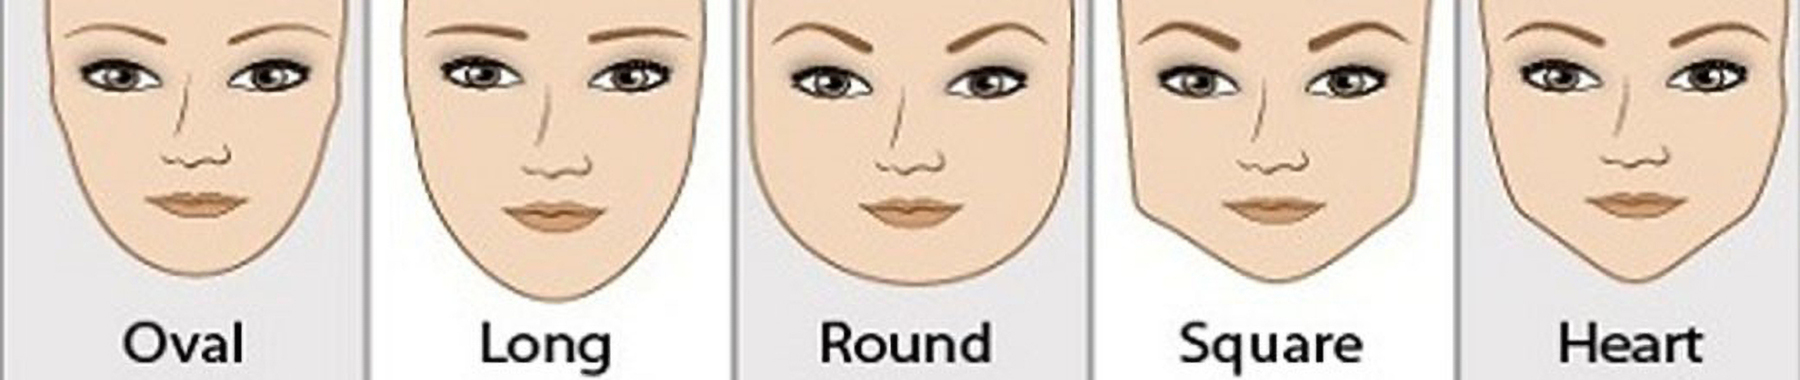

In [55]:
image_dir = "/content/test_images" # 얼굴형을 판단 할 이미지들이 있는 폴더 경로

filenames = os.listdir(image_dir) # 이미지 파일 리스트

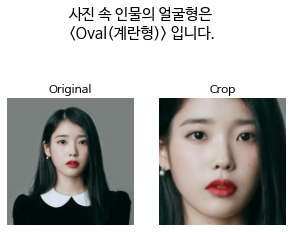

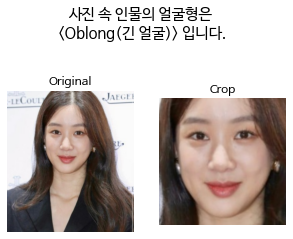

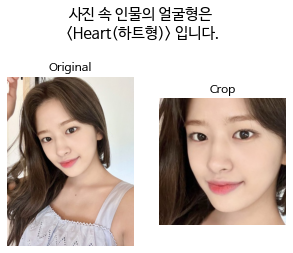

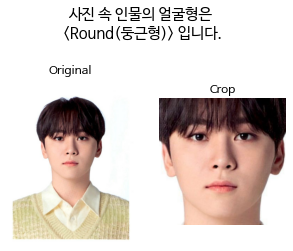

In [67]:
for i in filenames:
  file_path = image_dir + '/' + i # 이미지 파일 경로
  what_is_my_face_shape(file_path) # 얼굴형 판단 함수 적용

## 5. 마무리
- 아쉬운 점
    - 프로젝트를 처음 구상 할 때 얼굴형 판별 후 그에 따른 헤어스타일이나 패션을 추천해주는 서비스를 만들고 싶었으나 시간적 한계로 얼굴형 판별까지만 진행하게된
점
    - 만족스럽지 못한 모델 성능 
    
- 개선점
    - 추후에 시간적 여유가 있다면 더 다양한 데이터셋으로 충분한 학습을 통해 모델 성능 개선 및
얼굴형에 따른 헤어스타일, 패션 추천 서비스 제작에도 도전해보고 싶다.